In [4]:
from pathinit import *

import numpy as np
import scipy as sc


import jax
import jax.numpy as jnp
import jax.scipy as jsc   

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

2022-04-13 15:59:54.966252: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-13 15:59:55.143455: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-13 15:59:55.150385: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


# Le thème: Auto-différentiation appliquée sur des algorithmes

## Example de l'algorithme recursif d'extraction de la racine carrée d'un nombre

### version Numpy simple

In [5]:
def sqrt_rec(x):
    val = x
    for i in range(0,10):
        val = (val+x/val)/2.
    return val

### version JAX tout aussi simple: on bannit cependant l'usage de la boucle for

In [6]:
@jit
def jax_sqrt_rec(x):
    
    # struture: val = body(i,val)
    def body(i,val):
        return (val+x/val)/2.

    # struture: val =  loop(i_start, i_end, function, initialisation)
    return jax.lax.fori_loop(0,10,body,x)

## On applique le gradient que l'on vectorize 

In [10]:
vgradsqrt = vmap(grad(jax_sqrt_rec))

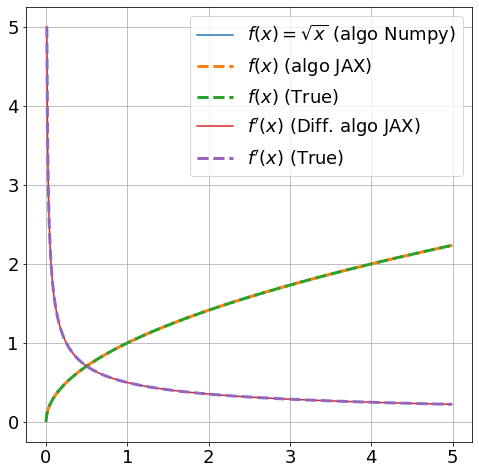

In [11]:
plt.figure(figsize=(8,8))
x = jnp.arange(0,5,0.01)
plt.plot(x, sqrt_rec(x), label=r"$f(x)=\sqrt{x}$ (algo Numpy)")
plt.plot(x, jax_sqrt_rec(x), lw=3,ls='--', label=r"$f(x)$ (algo JAX)")
plt.plot(x, jnp.sqrt(x), lw=3,ls='--', label=r"$f(x)$ (True)")

plt.plot(x, vgradsqrt(x), label=r"$f^\prime(x)$ (Diff. algo JAX)")

#plt.plot(x, vmap(grad(root))(x), label=r"$f^\prime(x)$ (Diff. algo Numpy)")  # Tout a fait possible mais moins Jax-idiom
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--',label=r"$f^\prime(x)$ (True)")
plt.legend()
plt.grid();

In [14]:
# Si vous êtes curieux: jax.make_jaxpr(jax_sqrt_rec)(1.)

# Code d'intégration de Simpson
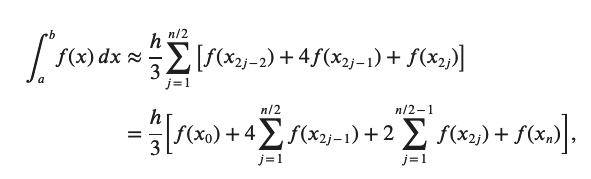
avec $n$ pair

In [66]:
# Version Numpy
def simps(f, a, b, N):
    assert N%2==0, f"use N even but get {N}"
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    w = np.ones_like(y)
    w[2:-1:2] = 2.
    w[1::2]   = 4.
    S = dx / 3. * np.einsum("i...,i...",w,y)
    return S

In [67]:
#version JAX
@partial(jit, static_argnums=(0,3))  # f et N ne seront des vecteurs
def jax_simps(f, a,b, N=512):
    assert N%2==0, f"use N even but get {N}"
    #N doit etre paire
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)
    y = f(x)
    w = jnp.ones_like(y)
    w = w.at[2:-1:2].set(2.)     # w est immutable
    w = w.at[1::2].set(4.)
    S = dx / 3. * jnp.einsum('i...,i...',w,y)
    return S

In [68]:
def func(x):
    return x**(1/10) * jnp.exp(-x)

In [69]:
a = 0.
b = a+0.5

In [70]:
simps(func, a, b, N=2**10)

0.32963201204750436

In [71]:
print(jax_simps(func, a, b, N=2**10))

0.32963201204750436


In [72]:
sc.special.gamma(1.+1./10)*(1.-sc.special.gammaincc(1.+1./10,0.5))

0.3296908257616642

### `jax.scipy` implémente un certain nombre de fonctionalités de `Scipy` mais pas toutes.

In [73]:
print(jnp.exp(jsc.special.gammaln(1.+1./10)) *(1.-jsc.special.gammaincc(1.+1./10,0.5)))

0.32969082576166414


## Le code de Simpson permet des calculs vectorisables directement

In [74]:
# Famille de functions
@jit
def jax_funcN(x):
    return jnp.stack([x**(i/10) * jnp.exp(-x) for i in range(50)],axis=1)

In [75]:
# lots d'intervalles d'integration [a,a+1/2] a:0,0.1,0.2...
ja = jnp.arange(0,20,0.1)
jb = ja+0.5

In [76]:
res = jax_simps(jax_funcN,ja,jb,  N=2**10)

In [77]:
res.shape

(50, 200)

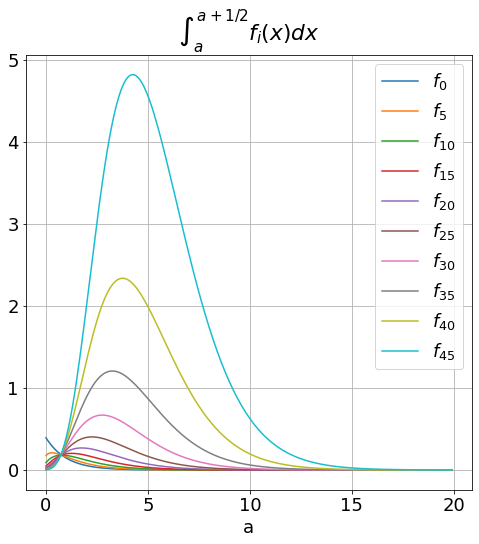

In [78]:
plt.figure(figsize=(8,8))
for i in range(0,50,5):
    plt.plot(ja,res[i,:],label=rf"$f_{{{i}}}$")
plt.xlabel("a")
plt.title(r"$\int_{a}^{a+1/2} f_i(x) dx$")
plt.grid()
plt.legend();

In [79]:
def fn(x,n):
    return x**(n/10) * jnp.exp(-x)
def test(n,z):
    return jax_simps(lambda z: fn(z,n),z,z+0.5,  N=2**10)

In [80]:
test(1.,0.)

DeviceArray(0.32963201, dtype=float64)

In [81]:
z = jnp.linspace(0.6,0.8,100)

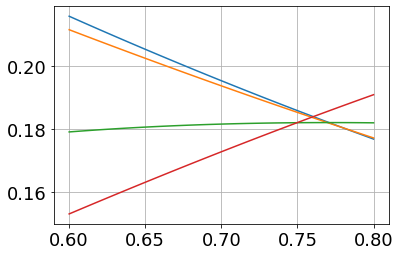

In [82]:
plt.plot(z,test(0.,z))
plt.plot(z,test(1.,z))
plt.plot(z,test(10.,z))
plt.plot(z,test(20.,z))
plt.grid()

# Vmap emboités
On derive `test` par rapport à `n` et on veut calculer ce gradiant pour ($n_i$) et $(z_j)$ collection de $i,j$

In [83]:
z = jnp.linspace(0.1,1.0,100)

In [84]:
res = vmap(vmap(grad(test, argnums=0), in_axes=(None,0)),in_axes=(0,None))(jnp.array([0.,10., 20., 50.]),z)

In [85]:
res.shape

(4, 100)

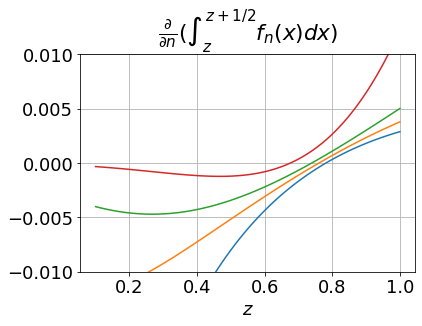

In [86]:
plt.plot(z,res[0,:])
plt.plot(z,res[1,:])
plt.plot(z,res[2,:])
plt.plot(z,res[3,:])
plt.ylim([-0.01,0.01])
plt.title(r"$\frac{\partial}{\partial n} (\int_{z}^{z+1/2} f_n(x) dx)$")
plt.xlabel(r"$z$")
plt.grid();

## Vérification que le Gradient de l'integration = la fonction

$$\Large \frac{d}{dx} \int_a^x f(z) dz = f(x)$$

In [87]:
f5 = lambda x: jnp.sqrt(x) * jnp.exp(-x)

In [88]:
intf5 = lambda x: jax_simps(f5,1e-7,x,N=2**10)

In [89]:
vintf5 = vmap(intf5)

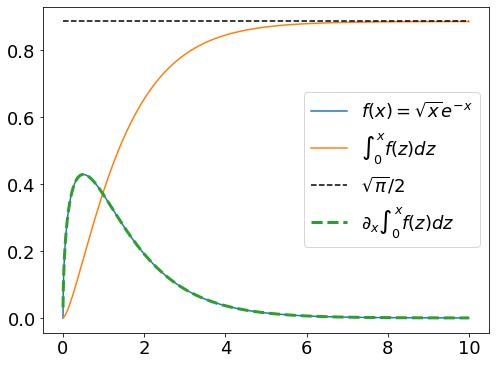

In [90]:
plt.figure(figsize=(8,6))
x = jnp.arange(0,10,0.001)
plt.plot(x,f5(x),label=r"$f(x)=\sqrt{x}e^{-x}$")
plt.plot(x,vintf5(x), label=r"$\int_0^x f(z)dz$")
plt.hlines(np.sqrt(np.pi)/2,x.min(),x.max(),colors='k',ls='--',label=r"$\sqrt{\pi}/2$")
plt.plot(x,vmap(grad(intf5))(x), ls="--", lw=3, label="$\partial_x \int_0^x f(z)dz$")
plt.legend();

# Une methode plus efficace d'integration: Quadrature de Clenshaw Curtis
Dans le fichier `CCquadInteg.py` on voit plusieurs petites choses
- quand un DeviceArray est crée il est `immutable` => opérations spéciales pour changer ses valeurs
- FFT incluse dans `jax.numpy`

In [91]:
tmp = jnp.ones(5)

In [92]:
tmp

DeviceArray([1., 1., 1., 1., 1.], dtype=float64)

In [93]:
tmp[0]=2

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [94]:
tmp = tmp.at[0].set(2.)
tmp = tmp.at[3].add(2.5)

In [95]:
tmp

DeviceArray([2. , 1. , 1. , 3.5, 1. ], dtype=float64)

## un peu de benchmarking: 1) warm-up pour la compilation, 2) `block_until_ready()`

In [96]:
#warm
%time tmp=jax_simps(jax_funcN,jnp.array([0]),jnp.array([1]),N=4).block_until_ready()

CPU times: user 387 ms, sys: 6.54 ms, total: 393 ms
Wall time: 385 ms


In [97]:
%timeit  res_sim = jax_simps(jax_funcN,ja,jb,N=2**15).block_until_ready()

24.3 s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
quad = ClenshawCurtisQuad(150)

In [101]:
#warm
%time tmp=quadIntegral(jax_funcN,jnp.array([0]),jnp.array([1]),quad).block_until_ready()

CPU times: user 340 ms, sys: 1.36 ms, total: 341 ms
Wall time: 335 ms


In [102]:
%timeit  res_cc=quadIntegral(jax_funcN,ja,jb,quad).block_until_ready()

38.5 ms ± 8.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [103]:
res_sim = jax_simps(jax_funcN,ja,jb,N=2**15)
res_cc=quadIntegral(jax_funcN,ja,jb,quad)

In [104]:
np.allclose(res_cc,res_sim,rtol=0.,atol=1e-6)  # atol=1e-7 => False

True

## Usage de  `jax.lax.scan`  https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html
```python
def scan(f, init, xs):
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

In [119]:
# ici t0: scalar et t:vecteur
def incremental_int(fn,t0,t, order=3):
    quad = ClenshawCurtisQuad(order)
    def integ(carry,t):
        y, t_prev = carry
        y = y + quadIntegral(fn,t_prev,t,quad)
        return (y,t),y
    (yf, _), y = jax.lax.scan(integ, (t0, jnp.array(t[0])), t)
    return y

In [120]:
quad=ClenshawCurtisQuad(150) 
tdef = jnp.linspace(0,10,4096)
res_cc_def = quadIntegral(f5,0.0,tdef,quad)

In [121]:
tinc = jnp.linspace(0,10,4096)
res_cc_inc = incremental_int(f5,0.0,tinc)

In [122]:
true_intf5 = lambda t: jnp.exp(jsc.special.gammaln(1.5))\
        *(1.-jsc.special.gammaincc(1.5,t))

In [123]:
t_val=jnp.linspace(0,10,4096)

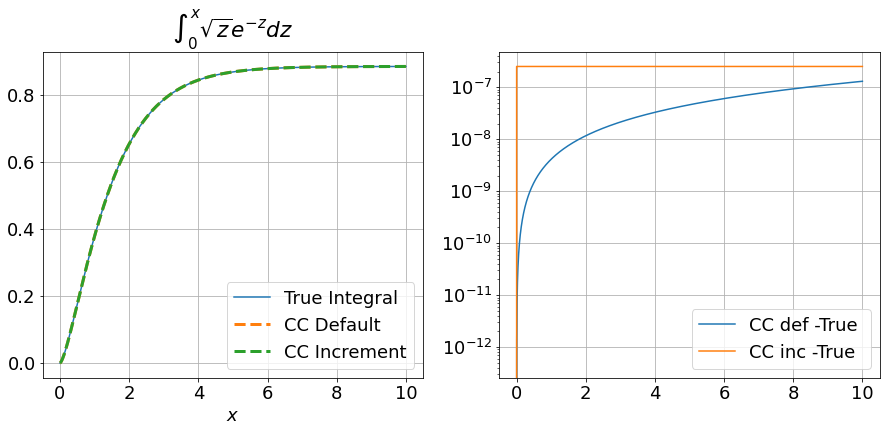

In [124]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(t_val, vmap(true_intf5)(t_val), label="True Integral")
ax[0].plot(t_val, jnp.interp(t_val,tdef,res_cc_def),lw=3,ls="--", label="CC Default")
ax[0].plot(t_val, jnp.interp(t_val,tinc,res_cc_inc),lw=3,ls="--", label="CC Increment")
ax[0].set_xlabel(r"$x$")
ax[0].legend()
ax[0].grid()
ax[0].set_title(r"$\int_0^x \sqrt{z} e^{-z} dz$");
#
ax[1].plot(t_val, jnp.abs(res_cc_def-vmap(true_intf5)(t_val)), label="CC def -True ")
ax[1].plot(t_val, jnp.abs(res_cc_inc-vmap(true_intf5)(t_val)), label="CC inc -True ")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid()

# Un peu de Cosmo: qq etudes autour des distances...

On va créer une classe PyTree 

In [125]:
from dataclasses import dataclass
from jax.tree_util import register_pytree_node_class

@dataclass(frozen=True)
class Constante:
    rh: float = 2997.92458  # h^{-1} Mpc
    H0: float = 100.0  # km/s/( h^{-1} Mpc)

const = Constante()


#The set of Python types that are considered internal PyTree nodes is extensible
@register_pytree_node_class
class Cosmology:
    def __init__(self, Omega_c, Omega_b, h, Omega_k, w0, wa):
        """
            Omega_c, float
              Cold dark matter density fraction.
            Omega_b, float
              Baryonic matter density fraction.
            h, float
              Hubble constant divided by 100 km/s/Mpc; unitless.
            Omega_k, float
              Curvature density fraction.
            w0, float
              First order term of dark energy equation
            wa, float
              Second order term of dark energy equation of state
        """
        # Store primary parameters
        self._Omega_c = Omega_c
        self._Omega_b = Omega_b
        self._h = h
        self._Omega_k = Omega_k
        self._w0 = w0
        self._wa = wa
    
        # Create a workspace where functions can store some precomputed
        # results
        self._workspace = {}

    def __str__(self):
        return (
              " h:"+ str(self.h)
            + " Omega_b:"+ str(self.Omega_b)
            + " Omega_c:"+ str(self.Omega_c)
            + " Omega_k:"+ str(self.Omega_k)
            + " w0:"+ str(self.w0)
            + " wa:"+ str(self.wa)
        )

    def __repr__(self):
        return self.__str__()

    # Operations for flattening/unflattening representation
    def tree_flatten(self):
        params = (
            self._Omega_c,
            self._Omega_b,
            self._h,
            self._Omega_k,
            self._w0,
            self._wa,
        )
        aux_data = None
        return (params, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        # Retrieve base parameters
        Omega_c, Omega_b, h, Omega_k, w0, wa = children

        return cls(
            Omega_c=Omega_c,
            Omega_b=Omega_b,
            h=h,
            Omega_k=Omega_k,
            w0=w0,
            wa=wa,
        )
    
    # Cosmological parameters, base and derived
    @property
    def Omega(self):
        return 1.0 - self._Omega_k

    @property
    def Omega_b(self):
        return self._Omega_b

    @property
    def Omega_c(self):
        return self._Omega_c

    @property
    def Omega_m(self):
        return self._Omega_b + self._Omega_c

    @property
    def Omega_de(self):
        return self.Omega - self.Omega_m

    @property
    def Omega_k(self):
        return self._Omega_k

    @property
    def k(self):
        return -jnp.sign(self._Omega_k).astype(jnp.int8)

    @property
    def sqrtk(self):
        return jnp.sqrt(jnp.abs(self._Omega_k))

    @property
    def h(self):
        return self._h

    @property
    def w0(self):
        return self._w0

    @property
    def wa(self):
        return self._wa

In [126]:
def z2a(z):
    """converts from redshift to scale factor"""
    return 1.0 / (1.0 + z)

def a2z(a):
    """converts from scale factor to  redshift"""
    return 1.0 / a - 1.0

def w(cosmo, a):
    """
    Linder 2003
     w(a) = w_0 + w_a (1 - a)
    """
    return cosmo.w0 + (1.0 - a) * cosmo.wa 

def f_de(cosmo, a):
    """
        f(a) = -3 (1 + w_0 + w_a) \ln(a) + 3 w_a (a - 1)
    """
    return -3.0 * (1.0 + cosmo.w0 + cosmo.wa) * jnp.log(a) + 3.0 * cosmo.wa * (a - 1.0)

def Esqr(cosmo, a):
    """
      E^2(a) = \Omega_m a^{-3} + \Omega_k a^{-2} + \Omega_{de} e^{f(a)} =H(a)^2/H0^2
    """
    return (
        cosmo.Omega_m * jnp.power(a, -3)
        + cosmo.Omega_k * jnp.power(a, -2)
        + cosmo.Omega_de * jnp.exp(f_de(cosmo, a))
    )

def H(cosmo, a):
    """
    H(a) = H0 * E(a)
    """
    return const.H0 * jnp.sqrt(Esqr(cosmo, a))

def dchioverda(cosmo, a):
    """
    \frac{d \chi}{da}(a) = \frac{R_H}{a^2 E(a)}
    """
    return const.rh / (a**2 * jnp.sqrt(Esqr(cosmo, a)))

def radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256):
    """
    \chi(a) =  R_H \int_a^1 \frac{da^\prime}{{a^\prime}^2 E(a^\prime)}
    """
    # Check if distances have already been computed
    if not "background.radial_comoving_distance" in cosmo._workspace.keys():
        # Compute tabulated array
        atab = jnp.logspace(log10_amin, 0.0, steps)


        def dchioverdlna(x):
            xa = jnp.exp(x)
            return dchioverda(cosmo, xa) * xa

        
        chitab_cc_inc = incremental_int(dchioverdlna, 0.0, jnp.log(atab), order=3)
        chitab_cc_inc = chitab_cc_inc[-1]-chitab_cc_inc
        
        cache = {"a": atab, "chi":chitab_cc_inc}
        cosmo._workspace["background.radial_comoving_distance"] = cache
    else:
        cache = cosmo._workspace["background.radial_comoving_distance"]

    #a = jnp.atleast_1d(a)
    # Return the results as an interpolation of the table
    return jnp.clip(jnp.interp(a, cache["a"], cache["chi"]), 0.0)

def transverse_comoving_distance(cosmo, a):
    r"""Transverse comoving distance in [Mpc/h] for a given scale factor.

    f_k : ndarray, or float if input scalar
        Transverse comoving distance corresponding to the specified
        scale factor.
    Notes
    -----
    The transverse comoving distance depends on the curvature of the
    universe and is related to the radial comoving distance through:
    .. math::
        f_k(a) = \left\lbrace
        \begin{matrix}
        R_H \frac{1}{\sqrt{\Omega_k}}\sinh(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for }\Omega_k > 0 \\
        \chi(a)&
            \mbox{for } \Omega_k = 0 \\
        R_H \frac{1}{\sqrt{\Omega_k}} \sin(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for } \Omega_k < 0
        \end{matrix}
        \right.
    """  
    index = cosmo.k + 1

    def open_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sinh(cosmo.sqrtk * chi / const.rh)

    def flat_universe(chi):
        return chi

    def close_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sin(cosmo.sqrtk * chi / const.rh)

    branches = (open_universe, flat_universe, close_universe)

    chi = radial_comoving_distance(cosmo, a)

    #def switch(index, branches, operand):
    #index = clamp(0, index, len(branches) - 1)
    #return branches[index](operand)

    return jax.lax.switch(cosmo.k + 1, branches, chi)

def angular_diameter_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_A(a) = a f_k(a)
    """
    return a * transverse_comoving_distance(cosmo, a)

def luminosity_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_L(a) = f_k(a) / a
    """
    return transverse_comoving_distance(cosmo, a)/a

$$
f_k(a) = \left\lbrace
        \begin{matrix}
        R_H \frac{1}{\sqrt{\Omega_k}}\sinh(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for }\Omega_k > 0 \\
        \chi(a)&
            \mbox{for } \Omega_k = 0 \\
        R_H \frac{1}{\sqrt{\Omega_k}} \sin(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for } \Omega_k < 0
        \end{matrix}
        \right.
$$ 

In [127]:
cosmo_jax = Cosmology(
    Omega_c=0.2545,
    Omega_b=0.0485,
    h=0.682,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0  
)

In [128]:
cosmo_jax.Omega_de   # 1 - Omega_k - cosmo_jax._Omega_m

0.6970000000000001

In [129]:
cosmo_jax.Omega_m,  cosmo_jax._Omega_b + cosmo_jax._Omega_c  # cosmo_jax._Omega_b + cosmo_jax._Omega_c

(0.303, 0.303)

In [130]:
1 - cosmo_jax.Omega_k - cosmo_jax.Omega_m

0.6970000000000001

In [131]:
luminosity_distance(cosmo_jax,0.1)

DeviceArray(64244.5349032, dtype=float64)

In [132]:
cosmo_jax.Omega_de + cosmo_jax.Omega_m

1.0

In [133]:
z = jnp.logspace(-3, 3,100)
chi_z = radial_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
trans_com_z = transverse_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
ang_diam_z= angular_diameter_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
lum_z = luminosity_distance(cosmo_jax, z2a(z)) / cosmo_jax.h

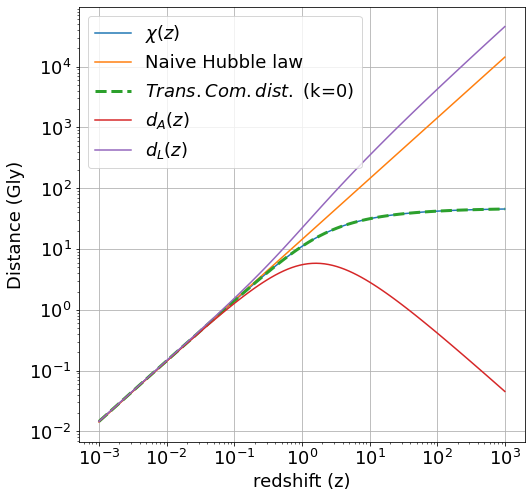

In [134]:
plt.figure(figsize=(8,8))
factMpc2Gly = 0.0032615 #Mpc -> Gly
plt.plot(z,factMpc2Gly * chi_z, label=r"$\chi(z)$")
plt.plot(z,factMpc2Gly * const.rh/cosmo_jax.h * z, label="Naive Hubble law")
plt.plot(z,factMpc2Gly * trans_com_z,ls="--",lw=3, label=rf"$Trans. Com. dist.$ (k={cosmo_jax.k})")
plt.plot(z,factMpc2Gly * ang_diam_z, label=r"$d_A(z)$")
plt.plot(z,factMpc2Gly * lum_z, label=r"$d_L(z)$")
plt.xlabel("redshift (z)")
plt.ylabel("Distance (Gly)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()

## gradient / vectorisation sur $\Omega_c$

In [137]:
omc=jnp.linspace(0.001,0.5,5)
#cosmo_jax = Cosmology(
#    Omega_c=0.2545,
#    Omega_b=0.0485,
#    h=0.682,
#    Omega_k=0.0,
#    w0=-1.0,
#    wa=0.0  
#)

In [138]:
def test(cosmo,z):
    return cosmo.Omega_c * z

In [139]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_c

DeviceArray([0.01, 0.1 , 1.  ], dtype=float64, weak_type=True)

In [140]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_b

DeviceArray([0., 0., 0.], dtype=float64, weak_type=True)

In [141]:
vlum = vmap(luminosity_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))
vang_diam = vmap(angular_diameter_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))

In [142]:
cosmo_cs = Cosmology(omc,cosmo_jax.Omega_b,cosmo_jax.h,cosmo_jax.Omega_k,cosmo_jax.w0,cosmo_jax.wa)

In [143]:
cosmo_cs.Omega_de[0]

DeviceArray(0.9505, dtype=float64)

In [144]:
data_lum=vlum(cosmo_cs,z2a(z))
data_lum /= cosmo_jax.h

In [145]:
data_ang_diam=vang_diam(cosmo_cs,z2a(z))
data_ang_diam /= cosmo_jax.h

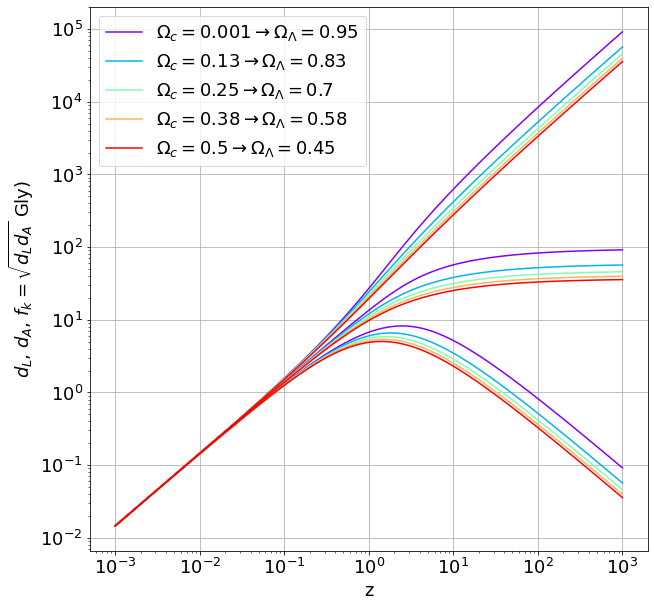

In [146]:
plt.figure(figsize=(10,10))
color = plt.cm.rainbow(np.linspace(0, 1, len(omc)))
for i,c in enumerate(omc):
    plt.plot(z, factMpc2Gly*data_lum[i,:], c=color[i],
             label=fr"$\Omega_c={c:.2}\rightarrow \Omega_{{\Lambda}}={cosmo_cs.Omega_de[i]:.2}$")
    plt.plot(z, factMpc2Gly*data_ang_diam[i,:], c=color[i])
    plt.plot(z, factMpc2Gly*np.sqrt(data_lum[i,:]*data_ang_diam[i,:]), c=color[i])
plt.legend()
plt.xlabel("z")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$d_L$, $d_A$, $f_k=\sqrt{d_L d_A}$ Gly)")
plt.grid();

# Etude spécifique sur $d_L$
##  Gradient de $d_L$ selon tous les paramètres

In [152]:
grad_lum = vmap(grad(luminosity_distance), in_axes=(None,0))(cosmo_jax,z2a(z))

## Exemple $\partial d_L /\partial \Omega_k$: vérifier ce calcul !

In [153]:
func = lambda a: -0.5*const.rh * (-1.+1./a**2) / (a**2 * Esqr(cosmo_jax, a)**1.5)
dLdOmega_k = quadIntegral(func,z2a(z),1.0,ClenshawCurtisQuad(100))*(1+z)

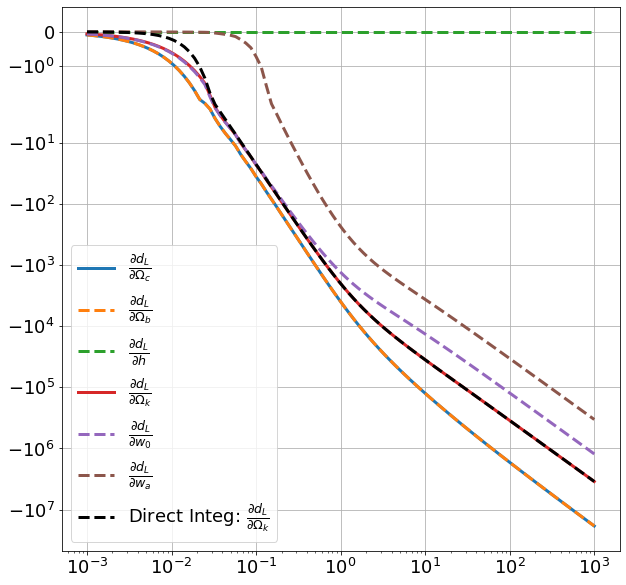

In [154]:
#cosmo_jax = Cosmology(
#    Omega_c=0.2545,
#    Omega_b=0.0485,
#    h=0.682,
#    Omega_k=0.0,
#    w0=-1.0,
#    wa=0.0  
#)
plt.figure(figsize=(10,10))
plt.plot(z,grad_lum.Omega_c/cosmo_jax.h,ls='-',lw=3,label=r"$\frac{\partial d_L}{\partial \Omega_c}$")
plt.plot(z,grad_lum.Omega_b/cosmo_jax.h,ls='--',lw=3, label=r"$\frac{\partial d_L}{\partial \Omega_b}$")
plt.plot(z,grad_lum.h/cosmo_jax.h,ls='--',lw=3, label=r"$\frac{\partial d_L}{\partial h}$")
plt.plot(z,grad_lum.Omega_k/cosmo_jax.h,ls='-',lw=3, label=r"$\frac{\partial d_L}{\partial \Omega_k}$")
plt.plot(z,grad_lum.w0/cosmo_jax.h,ls='--',lw=3, label=r"$\frac{\partial d_L}{\partial w_0}$")
plt.plot(z,grad_lum.wa/cosmo_jax.h,ls='--',lw=3, label=r"$\frac{\partial d_L}{\partial w_a}$")
plt.plot(z,dLdOmega_k/cosmo_jax.h, ls='--',lw=3,c='k',label=r"Direct Integ: $\frac{\partial d_L}{\partial \Omega_k}$")
plt.yscale("symlog")
plt.xscale("log")
plt.legend()
plt.grid();

# Exercices: 
- vérifier que $\partial d_L / \partial w_0$ est correct. 
- Changer de cosmologie
- répéter l'étude avec $d_A$ par exemple

# Takeaway messages:
- la différentiation d'algorithmes complexes est possible s'ils sont écrits en JAX
- des études complexes de dépendance vis-à-vis de paramètrs sont possibles assez simplement
- usage pratique des PyTree user
- `jax.scipy` implémente des fonctionalités de`Scipy`
- `jax.lax.scan`, `jax.lax.switch`
- le benchmarking demande de l'attention.